# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, **какой тариф приносит больше денег**.

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

🎯 Нужно проанализировать поведение клиентов и сделать вывод — **какой тариф лучше**.

## Changelog

- При слиянии датафреймов используется параметр `how='outer'` вместо `right` для того, чтобы получить записи по ключам из обоих датасетов;
- Дисперсия и другие метрики считаются не по агрегированным данным. Описание шага 3 ввело в заблуждение;
- Скорректированы выводы.

## Шаг 1. Откроем файлы с данными и изучим общую информацию

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

Для начала рассмотрим каждый из датасетов по отдельности. При необходимости будем соединять данные.

### Тарифы

In [3]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 208.0+ bytes


In [4]:
'''
    Сразу же переименуем колонку с названием тарифа, чтобы в дальнейшем у нас была возможность применить merge по ней.
    Также исправим ошибку в названии признака объёма интернет-трафика.
'''
tariffs = tariffs.rename(columns={'tariff_name': 'tariff', 'mg_per_month_included': 'mb_per_month_included'})

In [5]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


С типами данных все ок.

📝 Объём интернет-трафика, включённого в абонентскую плату, указан в мегабайтах, а стоимость дополнительного объема интернет-трафика в рублях за гигабайт.

### Пользователи

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.3+ KB


In [7]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [8]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [9]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [10]:
users.duplicated().sum()

0

* 📝 Нам доступны данные пятидесяти ста пользователей, 462 из которых все еще пользуются тарифом:
    * 351 – Смарт
    * 149 – Ультра
* 🆗 Пропусков, которые нужно заполнить, и дубликатов в данных нет;
* 📆 Следующие признаки необходимо привести к типу `DateTime`:
    * `reg_date` дата подключения тарифа;
    * `churn_date` дата прекращения пользования тарифом.

### Звонки


In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


⚠️ _«Мегалайн» всегда округляет вверх значения минут. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута._

In [12]:
len(calls[calls.duration < 1])

47927

In [13]:
calls.sort_values(['user_id', 'call_date']).head(10)

,id,call_date,duration,user_id
38,1000_38,2018-05-25,0.00,1000
78,1000_78,2018-05-26,10.25,1000
113,1000_113,2018-05-26,6.88,1000
133,1000_133,2018-05-26,4.19,1000
194,1000_194,2018-05-26,13.01,1000
335,1000_335,2018-05-26,1.91,1000
338,1000_338,2018-05-26,10.17,1000
274,1000_274,2018-05-27,3.43,1000
11,1000_11,2018-05-28,18.82,1000
124,1000_124,2018-05-28,0.00,1000


In [14]:
calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [15]:
calls.duplicated().sum()

0

* 📆 `call_date` приведем к `DateTime`;
* ❗️ ~20% звонков имеют продолжительность равную меньше 1 минуты. «Мегалайн» всегда округляет вверх значения минут. Выглядит как ошибка в данных. По-хорошему бы сходить к коллегам, которые делали выгрузку и уточнить почему так получилось. Один из вариантов – неправильный метод округления. Сделаем 2 шага для приведения данных в порядок:
    1. применим метод `np.ceil` для признака, тем самым получив верхнее значение в минутах;
    2. заменим нули на `1` – минимальное значение сессии звонка для оператора.

### Сообщения

In [16]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [17]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:
messages.isna().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [19]:
messages.duplicated().sum()

0

📆 `message_date` дату сообщения хорошо бы привести к `DateTime`.

### Интернет-сессии

In [20]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [21]:
internet.query("user_id == 1001 and session_date == '2018-11-14'")

,id,mb_used,session_date,user_id
227,1001_16,0.00,2018-11-14,1001
248,1001_37,0.00,2018-11-14,1001
260,1001_49,286.53,2018-11-14,1001
302,1001_91,0.00,2018-11-14,1001


In [22]:
len(internet.query('mb_used < 1'))

19699

In [23]:
internet.isna().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [24]:
internet.duplicated().sum()

0

* 📝 Объём потраченного за сессию интернет-трафика указан в мегабайтах, в то время, как тарификация в гигабайтах. Таким образом, если пользователь израсходует объем трафика, предоставленный тарифным планом, для анализа нам потребуется привести дополнительный объем трафика к гигабайтам, чтобы рассчитать стоимость;
* 📆 `session_date` дату интернет-сессии приведем к `DateTime`.
* ❗️ 19 699 сессий имеют объём потраченного за сессию интернет-трафика менее 1 Мб. Как и в случае со звонками, наш оператор округляет вверх значения мегабайтов. Поэтому выполним аналогичные 2 шага для приведения данных в порядок:
    1. применим метод `np.ceil` для признака, тем самым получив верхнее значение в минутах;
    2. заменим нули на `1` – минимальное значение сессии.

## Шаг 2. Подготовим данные

### Восстановим пропуски

In [25]:
# Звонки
calls['duration'] = calls['duration'].apply(np.ceil)
nonzero_session = calls['duration'] > 0
calls['duration'].where(nonzero_session, 1, inplace=True)
# Интернет-сессии
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
nonzero_session = internet['mb_used'] > 0
internet['mb_used'].where(nonzero_session, 1, inplace=True)

### Приведем данные к нужным типам

In [26]:
dtformat = '%Y-%m-%d'

def to_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=dtformat)

# Даты
to_datetime(users, ['reg_date', 'churn_date'])
to_datetime(calls, ['call_date'])
to_datetime(messages, ['message_date'])
to_datetime(internet, ['session_date'])
# Минуты и мегабайты
calls['duration'] = calls['duration'].astype('int64')
internet['mb_used'] = internet['mb_used'].astype('int64')

### Посчитаем значения, необходимые для анализа каждого пользователя

💡 _Мы рассматриваем выборочные совокупности в разрезе календарных месяцев. В качестве альтернативы могли бы рассмотреть в разрезе расчетного периода оператора._

In [27]:
costs = pd.DataFrame()

#### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [28]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [29]:
calls_by_month = calls.pivot_table(
    index=['month', 'user_id'],
    values='duration',
    aggfunc=['count', 'sum']
)

In [30]:
tmp_df = pd.DataFrame(calls_by_month.to_records())

In [31]:
costs['user_id'] = tmp_df['user_id']
costs['month']   = tmp_df['month']
costs['calls']   = tmp_df.iloc[:, 2]
costs['minutes'] = tmp_df.iloc[:, 3]

#### Количество отправленных сообщений по месяцам

In [32]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [33]:
messages_by_month = messages.pivot_table(
    index=['month', 'user_id'],
    values='id',
    aggfunc='count'
)

In [34]:
tmp_df = pd.DataFrame(messages_by_month.to_records()).rename(columns={'id': 'messages'})

In [35]:
costs = costs.merge(tmp_df, on=['user_id', 'month'], how='outer')

#### Объем израсходованного интернет-трафика по месяцам

In [36]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [37]:
internet_by_month = internet.pivot_table(
    index=['month', 'user_id'],
    values='mb_used',
    aggfunc='sum'
)

In [38]:
tmp_df = pd.DataFrame(internet_by_month.to_records())

In [39]:
costs = costs.merge(tmp_df, on=['user_id', 'month'], how='outer')
costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3174 non-null float64
minutes     3174 non-null float64
messages    2717 non-null float64
mb_used     3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


Таким образом, в одном датафрейме мы видим следующую информацию по пользователям в разрезе месяцев:

- количество сделанных звонков и израсходованных минут разговора;
- количество отправленных сообщений;
- объем израсходованного интернет-трафика в мегабайтах.

❗️ После формирования датафрейма по месяцам появились пропуски. Такое ощущение, что некоторые пользователи в некоторые месяцы пользовались не всеми услугами. Например, кто-то только мобильным интернетом. Заполним пропуски нулями и позже посмотрим на распределение.

In [40]:
na_features = ['calls', 'minutes', 'messages']

for f in na_features:
    # При соединении датафреймов Pandas привел типы к float64 из-за пропусков,
    # поэтому явно приведем их к int64
    costs[f] = costs[f].fillna(0).astype('int64')

In [41]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id     3214 non-null int64
month       3214 non-null int64
calls       3214 non-null int64
minutes     3214 non-null int64
messages    3214 non-null int64
mb_used     3203 non-null float64
dtypes: float64(1), int64(5)
memory usage: 175.8 KB


In [42]:
costs.head()

,user_id,month,calls,minutes,messages,mb_used
0,1005,1,15,99,7,2730.0
1,1032,1,61,397,38,24158.0
2,1045,1,1,9,5,2348.0
3,1055,1,64,568,30,17115.0
4,1071,1,24,200,16,15625.0


#### Помесячная выручка с каждого пользователя

In [43]:
# Для удобства добавим в датафрейм информацию о пользователях и тарифах
costs = costs.merge(users, on='user_id', how='left').merge(tariffs, on='tariff', how='left')

In [44]:
# Перерасход минут, сообщений и трафика посчитаем как разность между месячным значением и включенным в тариф
costs['minutes_over']  = costs['minutes'] - costs['minutes_included']
costs['messages_over'] = costs['messages'] - costs['messages_included']
costs['mb_used_over']  = costs['mb_used'] - costs['mb_per_month_included']

In [45]:
costs.head()

,user_id,month,calls,minutes,messages,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_over,messages_over,mb_used_over
0,1005,1,15,99,7,2730.0,67,NaT,Набережные Челны,Афанасий,...,50,15360,500,550,200,3,3,-401,-43,-12630.0
1,1032,1,61,397,38,24158.0,31,NaT,Ульяновск,Инна,...,50,15360,500,550,200,3,3,-103,-12,8798.0
2,1045,1,1,9,5,2348.0,48,NaT,Улан-Удэ,Джемма,...,50,15360,500,550,200,3,3,-491,-45,-13012.0
3,1055,1,64,568,30,17115.0,39,NaT,Казань,Луиза,...,50,15360,500,550,200,3,3,68,-20,1755.0
4,1071,1,24,200,16,15625.0,20,2018-08-31,Омск,Гектор,...,50,15360,500,550,200,3,3,-300,-34,265.0


⚠️ Положительные значения указывают на перерасход. Отрицательные на остаток в рамках тарифа.

In [46]:
def calc_monthly_revenue(row):
    """
    Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика,
    остаток умножим на значение из тарифного плана.
    """
    
    minutes_price = 0
    messages_price = 0
    mb_used_price = 0
    
    # стоимость дополнительных минут
    if row['minutes_over'] > 0:
        minutes_price = row['minutes_over'] * row['rub_per_minute']

    # стоимость дополнительных сообщений
    if row['messages_over'] > 0:
        messages_price = row['messages_over'] * row['rub_per_message']

    # стоимость дополнительного трафика
    if row['mb_used_over'] > 0:
        mb_used_price = (row['mb_used_over'] / 1024) * row['rub_per_gb']
    
    return minutes_price + messages_price + mb_used_price

In [47]:
costs['rub_monthly_fee_over'] = costs.apply(calc_monthly_revenue, axis=1)
costs['rub_monthly_fee_total'] = costs['rub_monthly_fee'] + costs['rub_monthly_fee_over']

In [48]:
# Датафрейм только с нужными нами данными
costs = pd.DataFrame(
    costs[['month', 'tariff', 'user_id', 'city',
           'calls', 'minutes', 'messages', 'mb_used',
           'minutes_over', 'messages_over', 'mb_used_over',
           'rub_monthly_fee_over', 'rub_monthly_fee_total']]
)

In [49]:
costs.head()

,month,tariff,user_id,city,calls,minutes,messages,mb_used,minutes_over,messages_over,mb_used_over,rub_monthly_fee_over,rub_monthly_fee_total
0,1,smart,1005,Набережные Челны,15,99,7,2730.0,-401,-43,-12630.0,0.000000,550.000000
1,1,smart,1032,Ульяновск,61,397,38,24158.0,-103,-12,8798.0,1718.359375,2268.359375
2,1,smart,1045,Улан-Удэ,1,9,5,2348.0,-491,-45,-13012.0,0.000000,550.000000
3,1,smart,1055,Казань,64,568,30,17115.0,68,-20,1755.0,546.773438,1096.773438
4,1,smart,1071,Омск,24,200,16,15625.0,-300,-34,265.0,51.757812,601.757812


In [50]:
smart_costs = costs.query("tariff == 'smart'")

In [51]:
len(smart_costs.groupby('user_id'))

350

In [52]:
ultra_costs = costs.query("tariff == 'ultra'")

In [53]:
len(ultra_costs.groupby('user_id'))

148

📝 В нашей результирующей таблицы оказались записи по 350 пользователям тарифа Смарт и 148 тарифа Ультра. Информации о расходах 2х пользователей не нашлось.

## Шаг 3. Анализируем данные

Опишем поведение клиентов оператора, исходя из выборки.

In [54]:
values = ['minutes', 'messages', 'mb_used', 'rub_monthly_fee_over', 'rub_monthly_fee_total']

In [55]:
# Сделаем сводную таблицу по тарифам в разрезе месяцев
tariff_monthly_costs = costs.pivot_table(
    index=['tariff', 'month'],
    values=values
)

In [56]:
smart_monthly_costs = tariff_monthly_costs.loc['smart']
smart_monthly_costs

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,8528.588235,18.235294,209.647059,154.895910,704.895910
2,11617.344828,24.086207,306.310345,262.159752,812.159752
3,15131.207792,31.857143,400.532468,583.213271,1133.213271
4,13486.080357,30.741071,377.000000,384.781878,934.781878
5,15832.751773,33.773050,398.404255,611.004377,1161.004377
6,15822.445122,33.402439,406.701220,614.601038,1164.601038
7,15771.398010,33.751244,419.288557,635.629392,1185.629392
8,16711.324786,33.638298,433.191489,726.647008,1276.647008
9,16332.615385,33.638462,440.080769,667.753456,1217.753456


In [57]:
ultra_monthly_costs = tariff_monthly_costs.loc['ultra']
ultra_monthly_costs

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
month,,,,,
1,13154.666667,33.777778,440.888889,0.000000,1950.000000
2,12860.000000,21.958333,304.666667,23.095703,1973.095703
3,17553.513514,32.297297,503.081081,54.254645,2004.254645
4,16845.254545,31.563636,470.072727,45.474077,1995.474077
5,19676.878788,37.850746,524.865672,105.022738,2055.022738
6,19172.168675,41.726190,492.428571,82.109724,2032.109724
7,20744.533333,49.846154,560.296703,158.562092,2108.562092
8,19780.745283,48.439252,524.570093,121.230195,2071.230195
9,19392.675439,52.286957,553.643478,63.776749,2013.776749


### Минуты разговора, количество сообщений и объём интернет-трафика в среднем необходимые пользователям каждого тарифа в месяц

In [58]:
tariff_usage = tariff_monthly_costs.pivot_table(
    index='tariff',
    values=values
)
tariff_usage

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
tariff,,,,,
smart,15091.033082,31.413211,397.374228,595.673948,1145.673948
ultra,18445.022099,43.714983,509.356551,88.972927,2038.972927


### 💡 Наблюдения

* Пользователи тарифа Ультра более активны, но пользователи тарифа Смарт тратят в среднем в 6 раз больше на дополнительные пакеты услуг. Оператор может использовать это для маркетинговой компании.
* Оператору больше денег приносит тариф Ультра, даже с учетом того, что в среднем пользователи не выходят за границы тарифных лимитов, а пользователи тарифа Смарт не тратят столько денег, чтобы перегнать стоимость тарифа Ультра. Таким образом, для пользователя выгоднее тариф Смарт.

### Москва и другие регионы

In [59]:
moscow = costs['city'] == 'Москва'
costs['city'].where(moscow, 'Другой регион', inplace=True)

city_monthly_costs = costs.pivot_table(
    index=['city', 'month'],
    values=values
)

In [60]:
city_usage = city_monthly_costs.pivot_table(
    index='city',
    values=values
)
city_usage

,mb_used,messages,minutes,rub_monthly_fee_over,rub_monthly_fee_total
city,,,,,
Другой регион,15758.440143,35.268458,424.594742,451.974045,1398.514093
Москва,17603.175813,33.944639,455.792652,388.889460,1483.854730


### 💡  Наблюдения

По средним значениям выручки пользователей Москвы и регионов мы видим, что разница не велика. Пользователи примерно отправляют одинаковое количество смс и звонят примерно одинаковое количество минут. В Москве чуть больше потребляют трафика – ожидаемо с учетом покрытия и скорости. Насколько получившиеся значения случайны мы узнаем при проверке гипотезы.

### Дисперсия и стандартное отклонение

Нормальное распредление определяют среднее и дисперсия. Они позволяют понять насколько шумные сейчас данные.

#### Минуты разговора

In [61]:
smart_costs['minutes'].describe()

count    2229.000000
mean      429.450875
std       194.871174
min         0.000000
25%       291.000000
50%       435.000000
75%       560.000000
max      1471.000000
Name: minutes, dtype: float64

In [62]:
ultra_costs['minutes'].describe()

count     985.000000
mean      540.779695
std       325.738740
min         0.000000
25%       292.000000
50%       532.000000
75%       773.000000
max      1727.000000
Name: minutes, dtype: float64

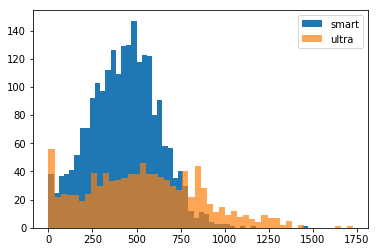

In [63]:
plt.hist(smart_costs['minutes'], bins=50, label='smart')
plt.hist(ultra_costs['minutes'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.show()

In [64]:
smart_minutes_var = np.var(smart_costs['minutes'], ddof=1)
ultra_minutes_var = np.var(ultra_costs['minutes'], ddof=1)

In [65]:
smart_minutes_var

37974.774627825

In [66]:
ultra_minutes_var

106105.72682307787

Результаты:

| Метрика                   | Смарт    | Ультра     |
|:-------------------------|----------|-----------|
| Стандартное отклонение (мин) | 194.87    | 325.73    |
| Дисперсия                 | 37,974.77 | 106,105.72 |

#### Количество сообщений

In [67]:
smart_costs['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

In [68]:
ultra_costs['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

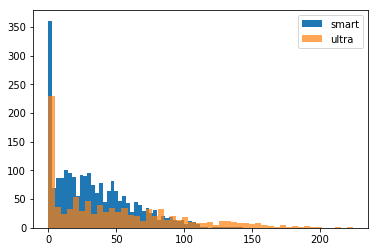

In [69]:
plt.hist(smart_costs['messages'], bins=50, label='smart')
plt.hist(ultra_costs['messages'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.show()

In [70]:
smart_messages_var = np.var(smart_costs['messages'], ddof=1)
ultra_messages_var = np.var(ultra_costs['messages'], ddof=1)

In [71]:
smart_messages_var

796.8129584480083

In [72]:
ultra_messages_var

2285.266142544674

Результаты:

| Метрика                        | Смарт    | Ультра    |
|:------------------------------|---------|-----------|
| Стандартное отклонение (сообщения) | 28.22    | 47.80    |
| Дисперсия                      | 796.81   | 2,285.27 |

#### Интернет-трафик

In [73]:
smart_costs['mb_used'].describe()

count     2228.000000
mean     16244.472172
std       5871.037024
min          1.000000
25%      12673.250000
50%      16541.500000
75%      20078.750000
max      38627.000000
Name: mb_used, dtype: float64

In [74]:
ultra_costs['mb_used'].describe()

count      975.000000
mean     19688.587692
std       9952.830482
min          1.000000
25%      12022.000000
50%      19416.000000
75%      26921.500000
max      49793.000000
Name: mb_used, dtype: float64

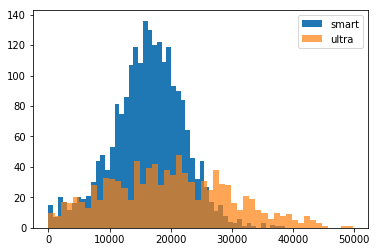

In [81]:
plt.hist(smart_costs['mb_used'], bins=50, label='smart')
plt.hist(ultra_costs['mb_used'], bins=50, label='ultra', alpha=0.7)
plt.legend(loc='upper right')
plt.show()

In [76]:
smart_mb_used_var = np.var(smart_costs['mb_used'], ddof=1)
ultra_mb_used_var = np.var(ultra_costs['mb_used'], ddof=1)

In [77]:
smart_mb_used_var

34469075.73833619

In [78]:
ultra_mb_used_var

99058834.60600853

Результаты:

| Метрика                         | Смарт         | Ультра         |
|:-------------------------------|---------------|---------------|
| Стандартное отклонение (Мб)        | 5,871.04      |  9,952.83     |
| Дисперсия                        | 34,469,075.73 | 99,058,834.60 |

🙇🏼‍♂️ _Перед тем, как делать расчеты и строить сводные таблицы, мы могли бы избавиться от выбросов в данных, но тогда был бы риск потерять часть датасета за какой-то временной промежуток из наших выборочных совокупностей._

## Шаг 4. Проверим гипотезы

Мы рассматриваем две генеральные сопокупности – пользователей разных тарифов мобильного оператора. Проверим две (двусторонние) гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам. Чтобы понять, различается ли средняя выручка пользователей разных тарифов и населенных пунктов, значима ли разница между средними значениями, проведем статистические тесты.

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

* Средняя выручка пользователя тарифа "Смарт":  1131.48 руб
* Средняя выручка пользователя тарифа "Ультра": 2039.91 руб

Нулевая гипотеза H₀:

> Средняя выручка пользователей тарифов "Ультра" и "Смарт" **не различается**

Исходя из H₀ формулируется альтернативная гипотеза H₁:

> Средняя выручка пользователей тарифов "Ультра" и "Смарт" **различается**

Пороговое значение `alpha` (критический уровень статистической значимости) зададим равным `1%`.

In [79]:
alpha = .01

results = st.ttest_ind(
    smart_costs['rub_monthly_fee_total'], 
    ultra_costs['rub_monthly_fee_total'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.009674149482176e-180
Отвергаем нулевую гипотезу


Средняя выручка по тарифам не одинакова, и практически нулевая вероятность говорит о том, что случайно получить такое отличие в значениях практически не получится. Следовательно, средняя выручка пользователей тарифов "Ультра" и "Смарт" действительно различается и наша гипотеза подтвердилась.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


* Средняя выручка пользователей из Москвы:          1464.53 руб
* Средняя выручка пользователей из других регионов: 1387.79 руб

Нулевая гипотеза H₀:

> Cредняя выручка пользователей из Москвы **не отличается** от выручки пользователей из других регионов

Исходя из H₀ формулируется альтернативная гипотеза H₁:

> Cредняя выручка пользователей из Москвы **отличается** от выручки пользователей из других регионов

Пороговое значение `alpha` (критический уровень статистической значимости) зададим равным `5%`.

In [80]:
alpha = .05

moscow = costs.query("city == 'Москва'")['rub_monthly_fee_total']
other_cities = costs.query("city == 'Другой регион'")['rub_monthly_fee_total']

results = st.ttest_ind(moscow, other_cities)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5220687323801865
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средняя выручка пользователей из Москвы и регионов неодинакова, с вероятностью в почти 52% такое различие можно получить случайно. Как мы уже знаем, это слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками. Таким образом, средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, и наша гипотеза не подтвердилась.

## Шаг 5. Общий вывод

Из двух наших гипотез подтвердилась только первая:

> Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Отвечая на вопрос "какой тариф лучше" исходя из вышеприведенного анализа выборочных совокупностей и гипотезы, можем сказать:

* для оператора – тариф Ультра
* для пользователя – тарифа Смарт